In [1]:
import io
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import tensorflow as tf
from keras.utils import normalize, to_categorical
import shutil

plt.style.use("ggplot")
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join('eye_dataset','data.csv'))

In [3]:
image_path = os.path.join('eye_dataset','dataset_eye','4793_left.jpeg')
label_file = os.path.join('eye_dataset','data.csv')

In [4]:
def load_image(image_name):
    image_path = os.path.join('eye_dataset', 'dataset_eye', f'{image_name}.jpeg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    
    return tf.cast(image,dtype=tf.float32)

In [5]:
def load_label(image_path:str):
    image_token = []
    label_token = []
    image_filename = image_path.split('\\')[-1].split('.')[0]
    with open (label_file ,'r') as f:
        files = f.readlines()
        for file in files[1:]:
            if image_filename == file.strip().split(',')[0]:
                image_token.append(file.strip().split(',')[0])
                label_token.append(file.strip().split(',')[1])
    return image_token,label_token

In [6]:
def convert_into_array(file):
    file = np.array(file,dtype=float)
    file = to_categorical(file,num_classes=5)
    file = tf.squeeze(file,axis=0)
    return file

In [7]:
def cropping_image(image):
    percentage = 0.02
    threshold = 0.1 * tf.reduce_mean(tf.boolean_mask(image, image != 0))
    img = tf.cast(image > threshold, tf.float32)

    row_sum = tf.reduce_sum(img, axis=1)
    col_sum = tf.reduce_sum(img, axis=0)
    rows = tf.where(row_sum > img.shape[1] * percentage)[:, 0]
    cols = tf.where(col_sum > img.shape[0] * percentage)[:, 0]

    min_row, min_col = tf.reduce_min(rows), tf.reduce_min(cols)
    max_row, max_col = tf.reduce_max(rows), tf.reduce_max(cols)

    img_crop = image[min_row:max_row + 1, min_col:max_col + 1]
    return tf.cast(img_crop,dtype = tf.float32)

In [8]:
def Normalization(image,image_size):
    
    image   = tf.image.resize(image,(image_size,image_size))
    mean_per_channel = tf.reduce_mean(image, axis=(0, 1))
    std_per_channel  = tf.math.reduce_std(image,axis=(0,1))
    
    epsilon = 1e-8
    std_per_channel = tf.maximum(std_per_channel, epsilon)

    # Normalize each channel by subtracting its respective channel mean from each pixel value
    normalized_rgb_image = image - mean_per_channel
    normalized_rgb_image = normalized_rgb_image/std_per_channel
    
    return tf.cast(normalized_rgb_image,dtype=tf.float32)

In [9]:
def preprocess(image_name,image_size = 256):
    image   = load_image(image_name)
    #image_c = cropping_image(image)
    image_n = Normalization(image,image_size)
    return tf.cast(image_n,dtype = tf.float32)

In [10]:
def load_data(path:str):
    path = bytes.decode(path.numpy())

    image,label = load_label(path)
    image = ''.join(image)
    label = convert_into_array(label)
    
    image_pre = preprocess(image,image_size=256)
    
    return image_pre,label

In [11]:
def mappable_function2(path:str):
    image,label = tf.py_function(load_data,[path],(tf.float32,tf.float32))
    image.set_shape([256,256,3])
    label.set_shape([5])
    return image,label

In [12]:
data = tf.data.Dataset.list_files('eye_dataset\\dataset_eye\\*.jpeg')
data = data.shuffle(buffer_size=500,reshuffle_each_iteration=False)
data = data.map(mappable_function2)
data = data.batch(32)
data = data.prefetch(tf.data.AUTOTUNE)

In [68]:
sample = data.as_numpy_iterator().next()

In [14]:
train_data = data.take(94)
test_data  = data.skip(94)

In [15]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,Conv2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50

In [16]:
model = Sequential()
model.add(ResNet50(input_shape=(256,256,3),include_top=False,weights=None))
for layer in model.layers:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(16,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units= 5, activation='softmax'))

In [27]:
early_stop    = EarlyStopping(monitor='val_loss',patience=20,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_1.h5",save_best_only=True)

In [28]:
loadModel = load_model('model_checkpoint_resume.h5')

In [29]:
loadModel.compile(optimizer =Adam() ,loss = 'categorical_crossentropy', metrics = ['accuracy','AUC'])

In [30]:
history = loadModel.fit(train_data,validation_data=test_data,epochs=50,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/50
94/94 [==============================] - 205s 2s/step - loss: 0.9811 - accuracy: 0.5711 - auc: 0.8728 - val_loss: 0.9489 - val_accuracy: 0.6441 - val_auc: 0.8845
Epoch 2/50
94/94 [==============================] - 203s 2s/step - loss: 0.9785 - accuracy: 0.5721 - auc: 0.8724 - val_loss: 0.8754 - val_accuracy: 0.6905 - val_auc: 0.9212
Epoch 3/50
94/94 [==============================] - 232s 2s/step - loss: 1.0036 - accuracy: 0.5688 - auc: 0.8662 - val_loss: 0.8236 - val_accuracy: 0.6779 - val_auc: 0.9197
Epoch 4/50
94/94 [==============================] - 718s 8s/step - loss: 1.0025 - accuracy: 0.5535 - auc: 0.8656 - val_loss: 0.8235 - val_accuracy: 0.7125 - val_auc: 0.9244
Epoch 5/50
94/94 [==============================] - 194s 2s/step - loss: 0.9710 - accuracy: 0.5738 - auc: 0.8753 - val_loss: 0.8814 - val_accuracy: 0.6551 - val_auc: 0.9041
Epoch 6/50
94/94 [==============================] - 298s 3s/step - loss: 0.9489 - accuracy: 0.5811 - auc: 0.8798 - val_loss: 1.0022 - v

94/94 [==============================] - 195s 2s/step - loss: 0.8887 - accuracy: 0.6150 - auc: 0.8961 - val_loss: 0.5911 - val_accuracy: 0.7848 - val_auc: 0.9640
Epoch 49/50
94/94 [==============================] - 193s 2s/step - loss: 0.8653 - accuracy: 0.6184 - auc: 0.9012 - val_loss: 1.2253 - val_accuracy: 0.5263 - val_auc: 0.8501
Epoch 50/50
94/94 [==============================] - 193s 2s/step - loss: 0.8763 - accuracy: 0.6087 - auc: 0.8982 - val_loss: 0.6609 - val_accuracy: 0.7431 - val_auc: 0.9448


In [47]:
early_stop    = EarlyStopping(monitor='val_loss',patience=20,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_2.h5",save_best_only=True)

In [48]:
loadModel = load_model('model_checkpoint_1.h5')

In [ ]:
def kappa_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    kappa = cohen_kappa_score(true_labels, y_pred_labels)
    return kappa

In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary predictions
    true_positives = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    actual_positives = tf.reduce_sum(y_true, axis=0)

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Handle NaN values
    return tf.reduce_mean(f1)

In [53]:
loadModel.compile(optimizer =Adam() ,loss = 'categorical_crossentropy', metrics = ['accuracy','AUC',f1_score])

In [54]:
history = loadModel.fit(train_data,validation_data=test_data,epochs=50,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/50
94/94 [==============================] - 206s 2s/step - loss: 0.8845 - accuracy: 0.6144 - auc: 0.8959 - f1_score: 0.5617 - val_loss: 0.9221 - val_accuracy: 0.6198 - val_auc: 0.9032 - val_f1_score: 0.5622
Epoch 2/50
94/94 [==============================] - 193s 2s/step - loss: 0.8526 - accuracy: 0.6110 - auc: 0.9030 - f1_score: 0.5612 - val_loss: 0.7256 - val_accuracy: 0.7141 - val_auc: 0.9361 - val_f1_score: 0.6510
Epoch 3/50
94/94 [==============================] - 196s 2s/step - loss: 0.8716 - accuracy: 0.6110 - auc: 0.8989 - f1_score: 0.5606 - val_loss: 0.7152 - val_accuracy: 0.7203 - val_auc: 0.9422 - val_f1_score: 0.6185
Epoch 4/50
94/94 [==============================] - 210s 2s/step - loss: 0.8662 - accuracy: 0.6164 - auc: 0.9014 - f1_score: 0.5715 - val_loss: 0.6003 - val_accuracy: 0.7714 - val_auc: 0.9591 - val_f1_score: 0.7215
Epoch 5/50
94/94 [==============================] - 198s 2s/step - loss: 0.8693 - accuracy: 0.6164 - auc: 0.9002 - f1_score: 0.5780 - val_lo

In [106]:
early_stop    = EarlyStopping(monitor='val_loss',patience=20,verbose=1)
checkpoint_cb = ModelCheckpoint("rms_prop_model.h5",save_best_only=True)

In [105]:
rms_model = load_model('model_checkpoint_2.h5',custom_objects={'f1_score':f1_score})

In [108]:
rms_model.compile(optimizer =RMSprop(centered=True) ,loss = 'categorical_crossentropy', metrics = ['accuracy','AUC',f1_score])

In [109]:
history_rms = rms_model.fit(train_data,validation_data=test_data,epochs=50,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/50
94/94 [==============================] - 210s 2s/step - loss: 0.8988 - accuracy: 0.6120 - auc: 0.8940 - f1_score: 0.5627 - val_loss: 0.5536 - val_accuracy: 0.7816 - val_auc: 0.9609 - val_f1_score: 0.7595
Epoch 2/50
94/94 [==============================] - 241s 3s/step - loss: 0.8418 - accuracy: 0.6356 - auc: 0.9061 - f1_score: 0.5887 - val_loss: 0.5528 - val_accuracy: 0.7887 - val_auc: 0.9621 - val_f1_score: 0.7490
Epoch 3/50
94/94 [==============================] - 234s 3s/step - loss: 0.8602 - accuracy: 0.6263 - auc: 0.9032 - f1_score: 0.5894 - val_loss: 0.6898 - val_accuracy: 0.7235 - val_auc: 0.9405 - val_f1_score: 0.7001
Epoch 4/50
94/94 [==============================] - 216s 2s/step - loss: 0.8723 - accuracy: 0.6120 - auc: 0.8989 - f1_score: 0.5680 - val_loss: 0.6594 - val_accuracy: 0.7628 - val_auc: 0.9458 - val_f1_score: 0.7439
Epoch 5/50
94/94 [==============================] - 197s 2s/step - loss: 0.8499 - accuracy: 0.6330 - auc: 0.9051 - f1_score: 0.5837 - val_lo

94/94 [==============================] - 210s 2s/step - loss: 0.8307 - accuracy: 0.6456 - auc: 0.9103 - f1_score: 0.6161 - val_loss: 1.0191 - val_accuracy: 0.6355 - val_auc: 0.9008 - val_f1_score: 0.5968
Epoch 36/50
94/94 [==============================] - 210s 2s/step - loss: 0.8257 - accuracy: 0.6433 - auc: 0.9106 - f1_score: 0.6046 - val_loss: 0.7265 - val_accuracy: 0.7062 - val_auc: 0.9333 - val_f1_score: 0.6714
Epoch 37/50
94/94 [==============================] - 208s 2s/step - loss: 0.8328 - accuracy: 0.6430 - auc: 0.9103 - f1_score: 0.6036 - val_loss: 0.5496 - val_accuracy: 0.7879 - val_auc: 0.9622 - val_f1_score: 0.7499
Epoch 38/50
94/94 [==============================] - 197s 2s/step - loss: 0.8385 - accuracy: 0.6396 - auc: 0.9086 - f1_score: 0.5960 - val_loss: 0.5777 - val_accuracy: 0.7690 - val_auc: 0.9574 - val_f1_score: 0.7437
Epoch 39/50
94/94 [==============================] - 198s 2s/step - loss: 0.8094 - accuracy: 0.6526 - auc: 0.9137 - f1_score: 0.6110 - val_loss: 0.5

In [122]:
trainig_history = {
    'loss'    :history_rms.history['loss'],
    'accuracy':history_rms.history['accuracy'],
    'auc'     :history_rms.history['auc'],
    'f1_score':history_rms.history['f1_score'],
    'val_loss':history_rms.history['val_loss'],
    'val_accuracy':history_rms.history['val_accuracy'],
    'val_auc'     :history_rms.history['val_auc'],
    'val_f1_score':history_rms.history['val_f1_score'],
}

In [124]:
his = pd.DataFrame(trainig_history)

In [125]:
his.to_csv('model_logs')

In [126]:
Adam_trainig_history = {
    'loss'    :history.history['loss'],
    'accuracy':history.history['accuracy'],
    'auc'     :history.history['auc'],
    'f1_score':history.history['f1_score'],
    'val_loss':history.history['val_loss'],
    'val_accuracy':history.history['val_accuracy'],
    'val_auc'     :history.history['val_auc'],
    'val_f1_score':history.history['val_f1_score'],
}

In [128]:
adam = pd.DataFrame(Adam_trainig_history)

In [129]:
adam.to_csv('adam_model_logs_64%')

In [111]:
def plot_model_perfomance(history):
    history_post_training = history.history

    train_loss = history_post_training['loss']
    test_loss = history_post_training['val_loss']

    train_accuracy = history_post_training['accuracy']
    test_accuracy = history_post_training['val_accuracy']

    train_AUC = history_post_training['auc']
    test_AUC = history_post_training['val_auc']
    

    plt.figure(1)
    plt.plot(test_loss, 'b-')
    plt.plot(train_loss, 'r-')

    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('loss graph', fontsize=12)
    plt.legend(['test','train'])

    plt.figure(2)
    plt.plot(train_accuracy, 'b-')
    plt.plot(test_accuracy, 'r-')

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.title('Accuracy graph', fontsize=12)
    plt.legend(['train','test'])
    
    plt.figure(3)
    plt.plot(test_AUC, 'b-')
    plt.plot(train_AUC, 'r-')

    plt.xlabel('iterations')
    plt.ylabel('AUC')
    plt.title('AUC graph', fontsize=12)
    plt.legend(['train','test'])
    
    plt.show()

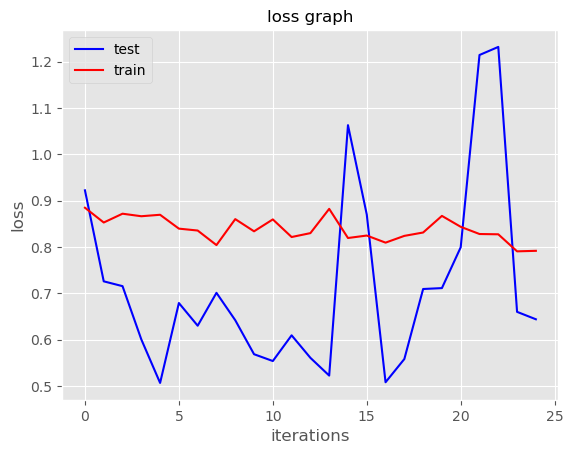

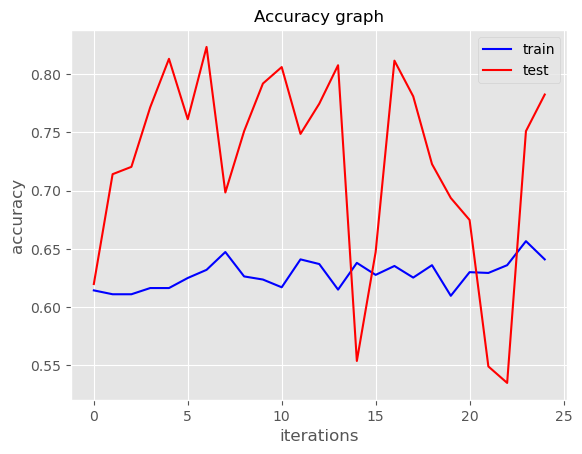

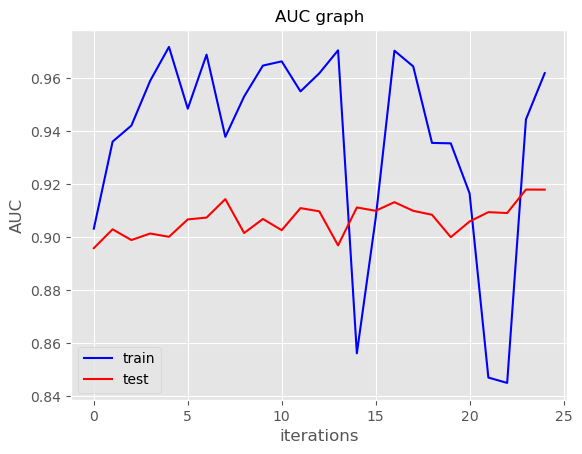

In [112]:
plot_model_perfomance(history)

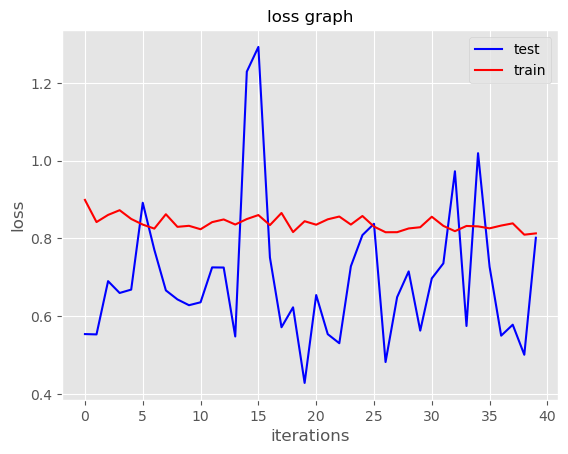

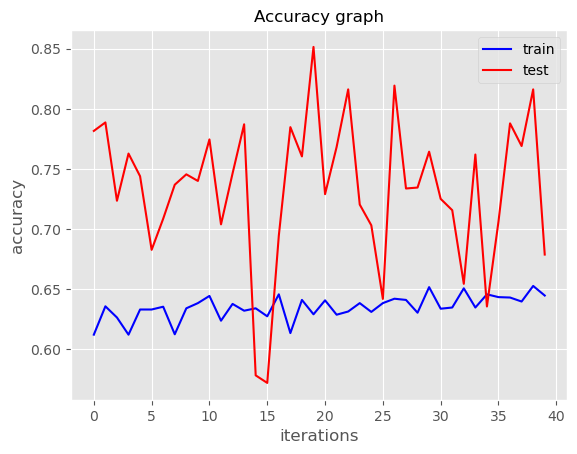

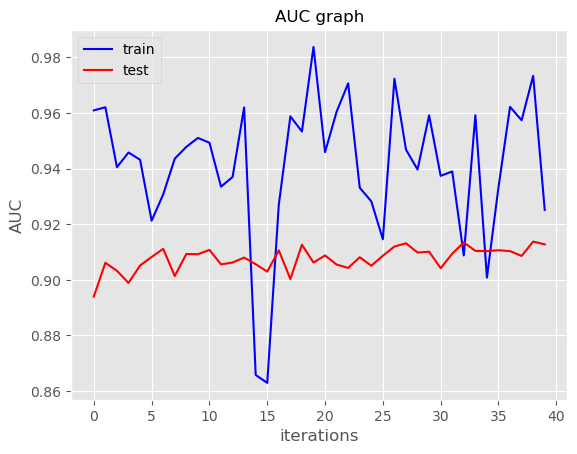

In [113]:
plot_model_perfomance(history_rms)